In [19]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
import numpyro.distributions as dist
from numpyro import sample, deterministic, plate
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# mlflow.set_experiment("Continuous Tempering Langevin")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim
save_directory = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Numpyro intro

In [23]:
import numpyro.distributions as dist

def model(p0, q0, q1, n):
    x = sample('X', dist.Bernoulli(p0))
    with plate(f'{n=}', n):
        y = sample('Y', dist.Bernoulli(q1**x * q0**(1-x)))
    return y

config = dict(p0=0.5, q0=0.5, q1=0.7, n=1)
model = partial(model, **config)
numpyro.render_model(model, render_distributions=True)

TypeError: model() missing 2 required positional arguments: 'q0' and 'q1'

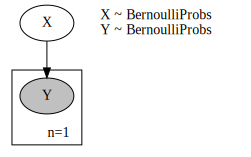

In [21]:
y_sample = {'Y':seed(model, 0)()}
obs_model = condition(model, y_sample)
logp = lambda x: log_density(obs_model, (), {}, {'X':x})[0]
numpyro.render_model(obs_model, render_distributions=True)

In [22]:
plt.figure()

plt.show()

<Figure size 640x480 with 0 Axes>

In [10]:
kernel = numpyro.infer.NUTS(obs_model, step_size=1e-2)
mcmc =  numpyro.infer.MCMC(kernel, num_warmup=0, num_samples=2, num_chains=3, chain_method='vectorized', progress_bar=True)
mcmc.run(jr.PRNGKey(42), extra_fields=['num_steps'])
samples = mcmc.get_samples()
extra = mcmc.get_extra_fields()
samples.update(extra)

sample: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


In [11]:
mcmc.last_state

HMCState(i=Array([2, 2, 2], dtype=int32), z={'Z': Array([-1.1576025 ,  0.02454335,  0.39629778], dtype=float32)}, z_grad={'Z': Array([-1.9918745 , -0.02351727, -0.25572863], dtype=float32)}, potential_energy=Array([2.572823 , 2.3174932, 2.254777 ], dtype=float32), energy=Array([4.6253414, 3.299024 , 4.903417 ], dtype=float32), r=None, trajectory_length=None, num_steps=Array([183, 143, 183], dtype=int32), accept_prob=Array([0.9999781, 0.9999842, 0.9997975], dtype=float32), mean_accept_prob=Array([0.9999888, 0.9999735, 0.9998973], dtype=float32), diverging=Array([False, False, False], dtype=bool), adapt_state=HMCAdaptState(step_size=Array([0.01, 0.01, 0.01], dtype=float32), inverse_mass_matrix={('Z',): Array([[1.],
       [1.],
       [1.]], dtype=float32)}, mass_matrix_sqrt={('Z',): Array([[1.],
       [1.],
       [1.]], dtype=float32)}, mass_matrix_sqrt_inv={('Z',): Array([[1.],
       [1.],
       [1.]], dtype=float32)}, ss_state=(Array([0., 0., 0.], dtype=float32), Array([0., 0., 0.

NameError: name 'samples' is not defined

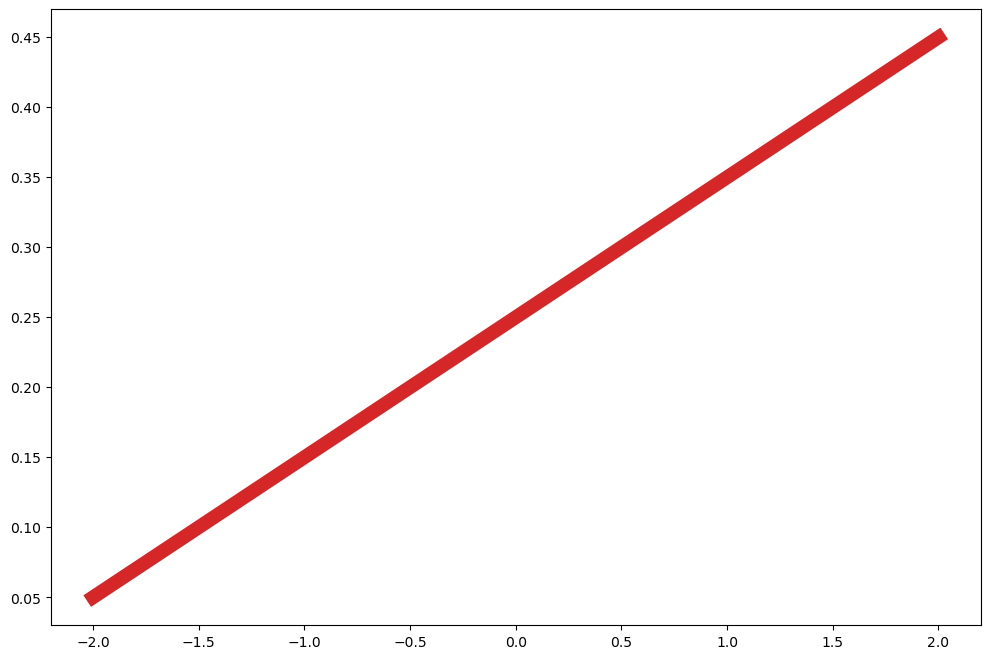

In [17]:
plt.figure(figsize=(12,8))
zs = jnp.linspace(-2,2,1000)
logps = jnp.exp(vmap(logp)(zs))
plt.plot(zs, logps / logps.mean() / 4, color='tab:red', linewidth=10)
plt.hist(samples['Z'], density=True, color='tab:orange', alpha=0.7, bins=20)
plt.ylim(0,0.42)
plt.axis('off')
plt.tight_layout()

In [35]:
np.bincount(samples['num_steps']), samples['num_steps'].sum()

(array([0, 1, 1, 1]), Array(6, dtype=int32))

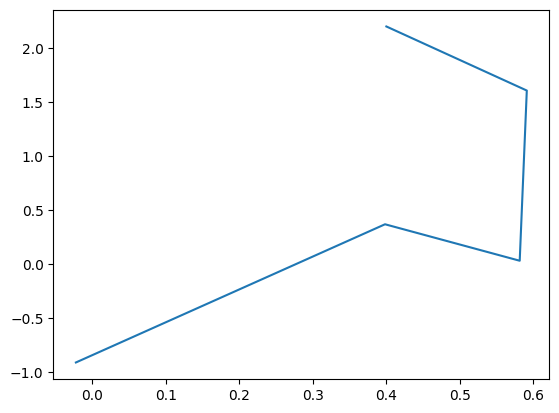

In [30]:
from matplotlib import rc
rc('animation', html='html5')
from matplotlib.animation import FuncAnimation
x, y = np.random.randn(2,10,5)

plt.figure()
line, = plt.plot(x[0], y[0])

def update(i):
    line.set_data(x[i], y[i])

anim = FuncAnimation(plt.gcf(), update, frames=10)
display(anim)
# anim.save("anim.mp4") # or .gif